In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools

colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:120])
markers = itertools.cycle(['o','s','v', ',', '+', '.', 'o', '*'])

from scipy.special import psi
from scipy.special import polygamma

plt.style.use(['seaborn-whitegrid'])
plt.rcParams.update({'font.size': 15})

current_dir = os.getcwd() 
kPSep = os.sep

# General pure states

We consider the system with $V$ modes dividing it on $V_A$ and $V_B$ subsystems such that $\mathcal{H}=\mathcal{H_A}\otimes\mathcal{H_B}$.
- $ f = V_A/V$
- $ d_A = 2 ^ {V_A}$
- $ d_B = 2 ^{V-V_A}$

We will the fraction number $f$ and with having the number of dimensions $D$ and fermionic nodes per site $N_{int}$

- $V=L^{D}N_{int}$
- $S_A(|\psi \rangle) = - \text{Tr}_{\mathcal{H_A}}\left[\hat{\rho}_A \ln \hat{\rho}_A \right] \quad \hat{\rho}_A = \text{Tr}_B |\psi\rangle\langle\psi|$ 



## Arbitrary number of particles

The average entanglement entropy of a uniformly distributed pure state in $\mathcal{H}$ restricted to subsystem A is given by the Page formula:
$$
    \langle S_A \rangle = 
    \left\{
    \begin{array}{lc}
        \Psi(d_Ad_B+1) - \Psi(d_B + 1) - \frac{d_A - 1}{2d_B}, & d_A\leq d_B \\
        \Psi(d_Ad_B+1) - \Psi(d_A + 1) - \frac{d_B - 1}{2d_A}, & \text{otherwise}
    \end{array}
    \right.,
$$

where $\Psi(x) = \Gamma ' (x) / \Gamma (x)$ is a digamma function.

Going to a thermodynamic limit, in big systems we can fix a fraction $f = V_A/V$ so what we get is:
$$
    \langle S_A \rangle = f V\ln 2 - 2 ^{-|1-2f|V-1} + O(2^{-V}),
$$
where we see the volueme law. For $f \neq \frac{1}{2}$, the second term is an exponentially small correction and becomes $-\delta _{f,1/2}$ as $V\rightarrow \infty$.

The variance is given for $d_A \leq d_B$:
$$
(\Delta S_A )^2 = \frac{d_A + d_B}{d_Ad_B + 1}\Psi ' (d_B + 1) - \Psi ' (d_Ad_B + 1) - \frac{(d_A - 1)(d_A + 2d_B - 1)}{4d_B^2(d_Ad_B + 1)},
$$
which again in the termodynamic limit becomes:
$$
(\Delta S_A )^2 = \left(\frac{1}{2}-\frac{1}{4}\delta_{f,1/2}\right)2^{-(1+|1-2f|)V}+o\left(2^{-(1+|1-2f|)V}\right).

# Function definitions

In [43]:
def page_result(d_a, d_b):
    if d_a <= d_b:
        return psi(d_a * d_b + 1) - psi(d_b + 1) - (d_a - 1)/(2*d_b)
    else:
        return psi(d_a * d_b + 1) - psi(d_a + 1) - (d_b - 1)/(2*d_a)

def page_result_var(d_a, d_b):
    return (((d_a + d_b)/(d_a*d_b + 1.0)) * polygamma(1, d_b + 1)) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2.0 * d_b - 1.0))/(4.0 * d_b * d_b * (d_a * d_b  + 1.0))

def page_thermodynamic(f, L, c = 1):
    return f * L * np.log(2.) - np.power(2., -np.abs(1-2*f)*L - 1) #+ c * np.power(2., -L)

def page_thermodynamic_var(f, L, c = 100):
    return (1/2 - 1/4 * (1.0 if f == 1/2 else 0.0)) * np.power(2., -(1+np.abs(1-2*f))*L) #+ c*np.power(2., -(1.0+np.abs(1-2*f))*L)

# Define the model

In [94]:
class ising_transverse:
    def __init__(self, Ns, J, J0, g, g0, h, w, sym = False, k = 0, p = 1, x = 1, bc = 0):
        self.N = 1
        self.Ns = 1
        self.N_full = 1
        self.all_symmetries = []
        self.real_symmetries = []
        self.bc = bc
        self.set_Ns(Ns)
        
        self.J = J
        self.J0 = J0
        self.g = g
        self.g0 = g0
        self.h = h
        self.w = w

        self.k = k
        self.p = p
        self.x = x
        self.sym = sym
        
    def set_Ns(self, Ns):
        self.Ns = Ns
        self.N = 1
        self.N_full = np.power(2, self.Ns)
        if self.bc == 0:
            self.all_symmetries = [(i, 1) for i in range(0, self.Ns)] + [(0, -1)] + ([(Ns//2, -1)] if self.Ns % 2 == 0 else [])
            self.real_symmetries = [str((0, 1)), str((0, -1))] + ([str((Ns//2, -1)), str((Ns//2, 1))] if self.Ns % 2 == 0 else [])
        else:
            self.all_symmetries = [(0, 1), (0, -1)]
            self.real_symmetries = [(0, 1), (0, -1)]
              
    def set_hilbert_space(self, energies):
        self.N = len(energies)
               
    def get_info(self):
        if not self.sym:
            return f"Ns={self.Ns},J={self.J:.2f},J0={self.J0:.2f},g={self.g:.2f},g0={self.g0:.2f},h={self.h:.2f},w={self.w:.2f},bc={self.bc}"
        else:
            return f"Ns={self.Ns},J={self.J:.2f},g={self.g:.2f},h={self.h:.2f},k={self.k:.2f},p={self.p},x={self.x},bc={self.bc}"
        
    def get_info_wo_sym(self):
        if not self.sym:
            return self.get_info()
        else:
            return f"Ns={self.Ns},J={self.J:.2f},g={self.g:.2f},h={self.h:.2f},bc={self.bc}"
    
    def get_dir(self, dir = "resultsSym"):
        directory = dir + str(self.Ns) + kPSep
        if self.sym:
            return directory + f"_ising_sym," + self.get_info() + kPSep
        else:
            return directory + f"_ising," + self.get_info() + kPSep
    
    def check_files(self, fraction, dir, name, columns):
        directory = self.get_dir(dir)
        
        tmp = None
        frac = fraction
        if not os.path.exists(directory):
            return pd.DataFrame(), frac
        
        files = os.listdir(directory)
        if fraction > 1:
            tmp = name + f"{int(fraction)}.dat"
            if tmp not in files:
                tmp = None
        else:
            tmp = None
            for file in files:
                if f"{fraction:.2f}x" in file and file.startswith(name):
                    tmp = file
                    frac = file.split("=")[-1][:-4]
                    break
        if tmp is not None:
            if columns is not None:
                return pd.read_csv(directory + tmp, names = columns, sep="\t"), frac
            else:
                return pd.read_csv(directory + tmp, sep="\t", header=None,), frac
        else:
            return pd.DataFrame(), frac
                
    def get_averages_file(self, fraction, dir = "{kPSep}resultsSym"):
        self.get_energy_file(fraction, dir)
        df, frac = self.check_files(
            fraction, 
            dir,
            "av_entropies,spectrum_num=",
            columns = ["L_a", "av_S", "empty"]
            )
        if len(df) == 0:
            return pd.DataFrame(), 1
        
        df['L_a'] = df['L_a'] / self.Ns
        return df.drop(["empty"], axis=1), frac
    
    def get_energy_file(self, fraction, dir = "{kPSep}resultsSym"):
        df, frac = self.check_files(
            fraction, 
            dir,
            "energies,spectrum_num=",
            columns = ["energy"]
            )
        if len(df) == 0:
            self.N = 0
            return pd.DataFrame(), 1
        
        self.set_hilbert_space(df)
        return df, frac
    
    def get_entropies_file(self, fraction, dir = "{kPSep}resultsSym"):
        self.get_energy_file(fraction, dir)
        
        df, frac = self.check_files(
            fraction, 
            dir,
            "entropies,spectrum_num=",
            columns = None
            )
        if len(df) == 0:
            self.N = 0
            return pd.DataFrame(), 1
        
        columns = df.columns
        df.rename(columns={0: "L_a"}, inplace = True)
        df['L_a'] = df['L_a'] / self.Ns
        #df.set_index(df[columns[0]], inplace=True)
        return df.drop(columns[-1], axis = 1), frac
    
    def concat_entropies(self, fraction, dir = "{kPSep}resultsSym", all = True):
        df = pd.DataFrame(columns = ['sector'] + [i/self.Ns for i in range(1, self.Ns//2 + 1)])
        
        syms = self.all_symmetries if all else [(self.k,self.p)]
        
        for i in syms:
            self.k = i[0]
            self.p = i[1]
            df_tmp, frac = self.get_entropies_file(fraction, dir)
            df_tmp2 = pd.DataFrame()
            for index, row in df_tmp.iterrows():
                L_a = row['L_a']
                values = row[df_tmp.columns[1:]]
                df_tmp2[L_a] = np.array(values)
            df_tmp2['sector'] = [(self.k,self.p) for i in range(len(df_tmp2))]
            
            df = df.append(df_tmp2, ignore_index = True)
        return df
            
    def get_variance(self, fraction, dir = "{kPSep}resultsSym"):
        df, frac = self.get_entropies_file(fraction, dir)
        if len(df) == 0:
            return pd.DataFrame(), 1
        
        col = (df[df.columns[1:]].var(axis = 1))
        df['var'] = col#np.square(col)
        return df[['L_a', 'var']], frac
    
    def symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", var = False):
        df = pd.DataFrame()
        df['L_a'] = np.array([i for i in range(1, self.Ns//2 + 1)]) / self.Ns
        
        col_name = 'av_S' if not var else 'var'
        N_all = 0
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            df_tmp, frac = self.get_averages_file(fraction, dir) if not var else self.get_variance(fraction, dir)
            if len(df_tmp) != 0:
                df[str(i) + f':{self.N}'] = np.array(df_tmp[col_name])
            else:
                print(f"\t->For {self.Ns} missing {'variance ' if var else ''}{i},frac={fraction}")
            N_all += self.N
        print(f"{('Did' if (self.N_full==N_all) else 'Didnt')} capture whole Hilbert space - for Ns = {self.Ns}")
        return df
    
    def average_symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", real = False, var = False):
        df = self.symmetry_sectors(fraction, dir, var)
        
        col_name = 'av_S' if not var else 'var'
        df[col_name] = [0.0 for i in range(len(df))]
    
        columns = df.columns
        columns = columns[1:-1]
        
        norm = 0
        for col in columns:
            N_tmp = int(col.split(':')[-1])
            sym = col.split(':')[0]
            if real and (sym not in self.real_symmetries):
                continue
            df[col_name] += N_tmp * df[col]
            norm += N_tmp
            
        df[col_name] /= norm
        return df[['L_a', col_name]], 1
        
        

# Plotters

## SINGLE PAGE'S

array([<AxesSubplot:title={'center':'Page result with digamma function for L=16'}, xlabel='f', ylabel='$<S_A>$'>,
       <AxesSubplot:title={'center':'Page result variance for L=16'}, xlabel='f', ylabel='$(\\Delta S_A )^2 _{page}$'>],
      dtype=object)

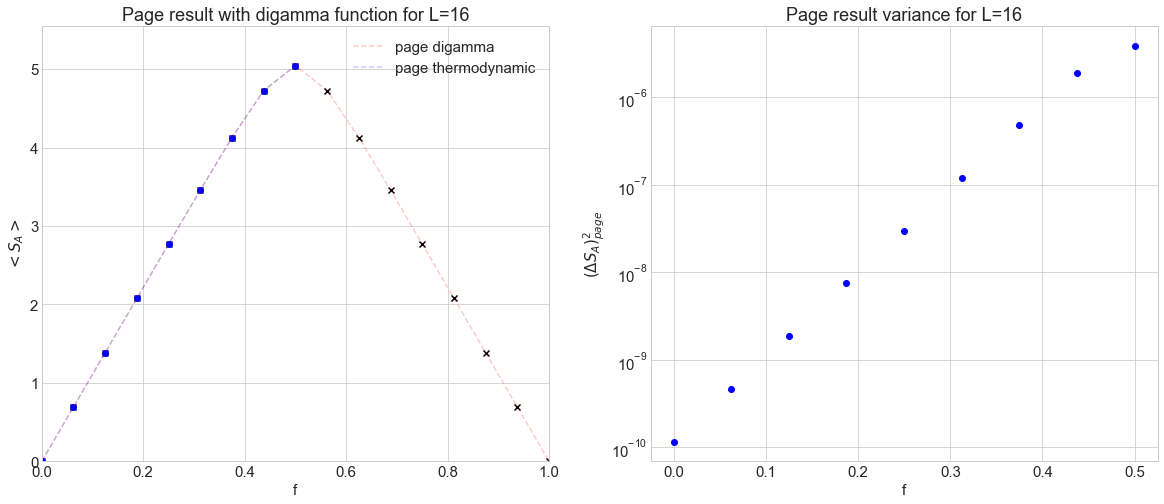

In [45]:
def plot_page(L, legend = True):
    N = np.power(2, L)
    fig, ax = plt.subplots(1,2, figsize = (20,8))
    ax[0].set_xlabel("f")
    ax[1].set_xlabel("f")
    ax[0].set_ylabel("$<S_A>$")
    ax[1].set_ylabel("$(\Delta S_A )^2 _{page}$")
    constant = 1
    constant2 = 10000/L
    points = []
    pages = []
    pages_thermo = []
    for L_a in np.arange(0, L+1):
        d_a = np.power(2, L_a)
        d_b = np.power(2, L-L_a)
        f=L_a/L
        page = page_result(d_a, d_b)
        page_var = page_result_var(d_a, d_b)
        page_therm = page_thermodynamic(f, L, constant)
        page_therm_var = page_thermodynamic_var(f, L, constant2)
        
        ax[0].scatter(f, page, c='black', marker ='x')
        if(L_a <= L//2):
            ax[0].scatter(f, page_therm, c='blue', marker ='o')
            #ax[1].scatter(f, page_var, c='black', marker ='x')
            ax[1].scatter(f, page_therm_var, c='blue',marker ='o')
        
        points.append(f)
        pages.append(page)
        
        pages_thermo.append(page_therm)
        
    ax[0].plot(points, pages, color='red', ls = '--', alpha = 0.2, label = "page digamma")
    ax[0].plot(points[0:-L//2], pages_thermo[0:-L//2], color='blue', ls = '--', alpha = 0.2, label = "page thermodynamic")
    if legend:
        ax[0].legend()
    ax[0].set_title(f"Page result with digamma function for L={L}")
    ax[1].set_title(f"Page result variance for L={L}")
    
    ax[1].set_yscale('log')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1/2 * L * np.log(2) + constant * np.power(2., -L)])
    return ax
plot_page(16)

## Many Page's

(array([[<AxesSubplot:title={'center':'Average entropy over different lattice sizes'}, xlabel='f', ylabel='$<S_A>$'>,
         <AxesSubplot:title={'center':'Average entropy density over different lattice sizes'}, xlabel='f', ylabel='$<S_A>/V$'>],
        [<AxesSubplot:title={'center':'Average entropy variance over different lattice sizes'}, xlabel='f', ylabel='$(\\Delta S_A )^2 _{page}$'>,
         <AxesSubplot:title={'center':'$[0.5*V*\\ln{2} - 0.5] - <S_A>$'}, xlabel='$V$', ylabel='$S_{max} - <S_A>$'>],
        [<AxesSubplot:title={'center':'$[\\Psi(d_Ad_B+1) - \\Psi(d_B + 1) - (d_A - 1)/(2d_B)] - <S_A>$'}, xlabel='$V$', ylabel='$S_{\\Psi} - <S_A>$'>,
         <AxesSubplot:title={'center':'Entropy samples for different system sizes'}, xlabel='$f$', ylabel='$<S_A>$'>]],
       dtype=object),
 {6: ',', 10: '+', 14: '.', 18: 'o', 20: '*'},
 {6: 'tab:red',
  10: 'tab:purple',
  14: 'tab:brown',
  18: 'tab:pink',
  20: 'tab:gray'})

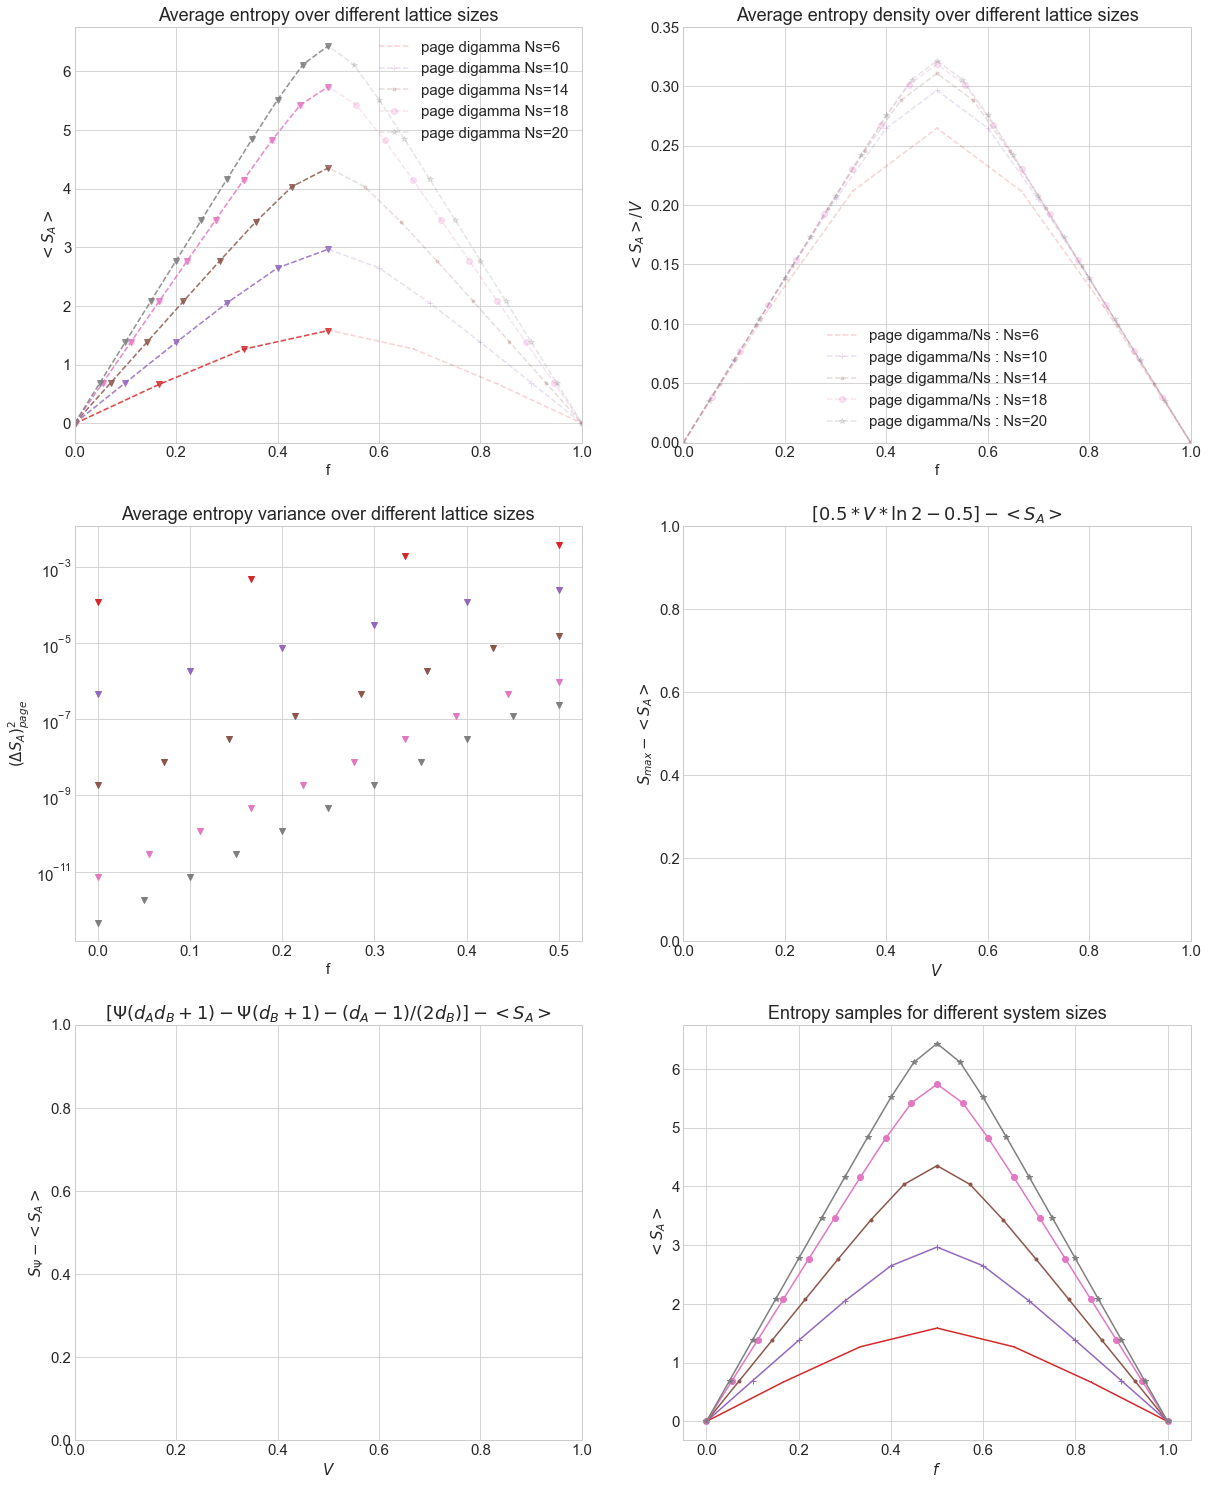

In [160]:
def plot_pages(L, legend = True):
    fig, ax = plt.subplots(3,2, figsize = (20,26))
    ax[0][0].set_xlabel("f")
    ax[0][1].set_xlabel("f")
    ax[1][0].set_xlabel("f")
    ax[0][0].set_ylabel("$<S_A>$")
    ax[0][1].set_ylabel("$<S_A>/V$")
    ax[1][0].set_ylabel("$(\Delta S_A )^2 _{page}$")
    
    ax[1][1].set_xlabel("$V$")
    ax[1][1].set_ylabel("$S_{max} - <S_A>$")
    ax[1][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$")
    #ax[1][1].set_title("$fV\ln{2} - 2 ^{-|1-2f|V-1} - <S_A>$")
    ax[2][0].set_xlabel("$V$")
    ax[2][0].set_ylabel("$S_{\Psi} - <S_A>$")
    ax[2][0].set_title("$[\Psi(d_Ad_B+1) - \Psi(d_B + 1) - (d_A - 1)/(2d_B)] - <S_A>$")
    
    ax[2][1].set_xlabel("$f$")
    ax[2][1].set_ylabel("$<S_A>$")
    ax[2][1].set_title("Entropy samples for different system sizes")
    
    col = {}
    mark = {}
    
    for l in L:  
        N = np.power(2, l)
        constant = 1
        constant2 = 10000/l
    
        points = []
        pages = []
        pages_thermo = []
        
        color_page = next(colors_ls_cyc)
        marker_page = next(markers)
        color_page_therm = color_page
        marker_page_therm = 'v'
        for L_a in np.arange(0, l+1):
            d_a = np.power(2, L_a)
            d_b = np.power(2, l-L_a)
            f=L_a/l
            
            mark[l] = marker_page
            col[l] = color_page
            
            page = page_result(d_a, d_b)
            page_var = page_result_var(d_a, d_b)
            page_therm = page_thermodynamic(f, l, constant)
            page_therm_var = page_thermodynamic_var(f, l, constant2)
            
            if(L_a <= l//2):
                #ax[1][0].scatter(f, page_var, c=color_page, marker = marker_page)
                ax[1][0].scatter(f, page_therm_var, c=color_page_therm, marker = marker_page_therm)
            
            points.append(f)
            pages.append(page)
            pages_thermo.append(page_therm)
        
        ax[0][0].plot(points, pages, color=color_page, marker = marker_page, ls = '--',
                   alpha = 0.2, label = f"page digamma Ns={l}")
        ax[2][1].plot(points, pages, color=color_page, marker = marker_page, ls = '-',
                   alpha = 1.0, label = f"page digamma Ns={l}")
        
        ax[0][1].plot(points, np.array(pages)/l, color=color_page, marker = marker_page, ls = '--',
                    alpha = 0.2, label = f"page digamma/Ns : Ns={l}")
       
        ax[0][0].plot(points[0:-l//2], pages_thermo[0:-l//2], color=color_page_therm,
                   marker = marker_page_therm, ls = '--',
                   alpha = 0.8)

        
    ax[0][0].set_title(f"Average entropy over different lattice sizes")
    ax[0][1].set_title(f"Average entropy density over different lattice sizes")
    ax[1][0].set_title(f"Average entropy variance over different lattice sizes")
    ax[0][0].set_xlim([0, 1])
    
    ax[1][0].set_yscale('log')
    ax[0][1].set_xlim([0, 1])
    ax[0][1].set_ylim([0, np.log(2) * 1/2])
    ax[0][1].set_yticks([0.05 * i for i in range(0, 8)])
    if legend:
        ax[0][0].legend()
        ax[0][1].legend()
    #ax[0].set_ylim([0, 1/2 * L * np.log(2) + constant * np.power(2., -L)])
    return ax, mark, col
plot_pages([6,10,14,18,20])

## Averages plot

In [155]:
def plot_model_av(model, frac, directory = f"{kPSep}resultsSym"):
    df, fraction = model.get_averages_file(frac, directory)
    df_var, fraction = model.get_variance(frac, directory)
    ax = plot_page(model.Ns, False)
    ax[0].plot(df['L_a'], df['av_S'], label = model.get_info())
    ax[1].plot(df_var['L_a'], df_var['var'], label = model.get_info(), marker = 'x')
    ax[0].legend()
    ax[1].legend()
    return df, fraction
    
def plot_many_scatters(df, ax, color, marker, l, label):
    minima = []
    averages = []
    seventy_fives = []
    quoters = []
    pages = []
    for col in df.columns[1:]:
        x = [float(col) for i in range(len(df))]
        ax.scatter(x, np.array(df[col]), color = color, marker = marker, s = 2, alpha = 0.1)
        minima.append(np.min(np.array(df[col])))
        averages.append(np.average(np.array(df[col])))
        seventy_fives.append(np.quantile(np.array(df[col]),0.75))
        quoters.append(np.quantile(np.array(df[col]), 0.25))
    # pages only
    for L_a in np.arange(1, l//2 + 1):
        d_a = np.power(2, L_a)
        d_b = np.power(2, l-L_a)
        pages.append(page_result(d_a, d_b))
        
    x = [i/l for i in range(1,l//2+1)]
    
    ax.fill_between(np.array(x), minima, pages, color=color, alpha=0.2, interpolate=True)
    ax.fill_between(np.array(x), quoters, pages, color=color, alpha=0.1, interpolate=True)
    ax.fill_between(np.array(x), averages, pages, color=color, alpha=0.3, interpolate=True)
    ax.fill_between(np.array(x), seventy_fives, pages, color=color, alpha=0.5, interpolate=True, label = label)

def plot_model_avs(L, model, frac, directory = f"{kPSep}resultsSym", one_sector = True, real = False):
    ax, markers, colors = plot_pages(L, False)
    
    points = []
    points_page = []
    df = pd.DataFrame()
    df_var = pd.DataFrame()
    df_all = pd.DataFrame()
    for l in L:
        model.set_Ns(l)

        if one_sector:
            df, fraction = model.get_averages_file(frac, directory)
            df_var, fraction = model.get_variance(frac, directory)
            df_all = model.concat_entropies(frac, directory, all = False)
        else:
            df, fraction = model.average_symmetry_sectors(frac, directory, real, False)
            df_var, fraction = model.average_symmetry_sectors(frac, directory, real, True)
            df_all = model.concat_entropies(frac, directory, all = True)
            
    
        label = model.get_info() if one_sector else model.get_info_wo_sym()
        plot_many_scatters(df_all, ax[2][1], colors[l], markers[l], l, label = label)            
        ax[0][0].plot(df['L_a'], df['av_S'], label = label, color = colors[l], marker=markers[l])
        ax[0][1].plot(df['L_a'], df['av_S']/l, label = label, color = colors[l], marker=markers[l])
        ax[1][0].plot(df_var['L_a'], df_var['var'], label = label, color = colors[l], marker=markers[l])
        
        # plot the differences
        val = 1/2 * l * np.log(2) - 1/2
        point = val - df[df['L_a']==1/2]['av_S']
        point_page = page_result(np.power(2, l//2), np.power(2, l//2)) - df[df['L_a']==1/2]['av_S']
        ax[1][1].scatter(l, point, marker = 'v', color = 'red')
        ax[2][0].scatter(l, point_page, marker = 'v', color = 'red')
        points.append(point)
        points_page.append(point_page)
    
    label = model.get_info()[6:] if one_sector else model.get_info_wo_sym()[6:]
    ax[1][1].plot(L, points, marker = 'v', label = label, ls = '--', alpha = 0.2)
    ax[1][1].set_xlim([L[0], L[-1]])
    ax[1][1].set_xticks(np.arange(np.min(L), np.max(L) + 1, 1))
    ax[1][1].set_yscale('log')
    
    ax[2][0].plot(L, points_page, marker = 'v', label = label, ls = '--', alpha = 0.2)
    ax[2][0].set_xlim([L[0], L[-1]])
    ax[2][0].set_xticks(np.arange(np.min(L), np.max(L) + 1, 1))
    ax[2][0].set_yscale('log')
    
    
    average_name = "ED states" if not model.sym else (f"single sector {(model.k, model.p)}" if one_sector else ("real sectors" if real else "all sectors"))
    
    ax[0][0].set_title(f"Average entropy over {average_name} for different lattice sizes")
    ax[0][1].set_title(f"Average entropy density over {average_name} for different lattice sizes")
    ax[1][0].set_title(f"Average entropy variance over {average_name} for different lattice sizes")
    
    ax[0][0].legend()
    ax[0][1].legend()
    ax[1][0].legend()
    ax[1][1].legend()
    ax[2][1].legend()
        

# Tests

### MODEL

In [156]:
Ns = 12
bc = 0
g = 0.90
h = 0.81

J=1.0
w = 0.0
g0 = 0.0
J0 = 0.0

sym = True
k = 0
p = 1
x = 1


fraction=0.2

model = ising_transverse(Ns, J, J0, g, g0, h, w, sym, k, p, x, bc)

directory = current_dir + f"{kPSep}res{kPSep}resultsSym"
#model.concat_entropies(fraction, directory, False)

### SINGLE

(        L_a      av_S
 0  0.083333  0.688207
 1  0.166667  1.370230
 2  0.250000  2.027630
 3  0.333333  2.639150
 4  0.416667  3.144720
 5  0.500000  3.388640,
 '44')

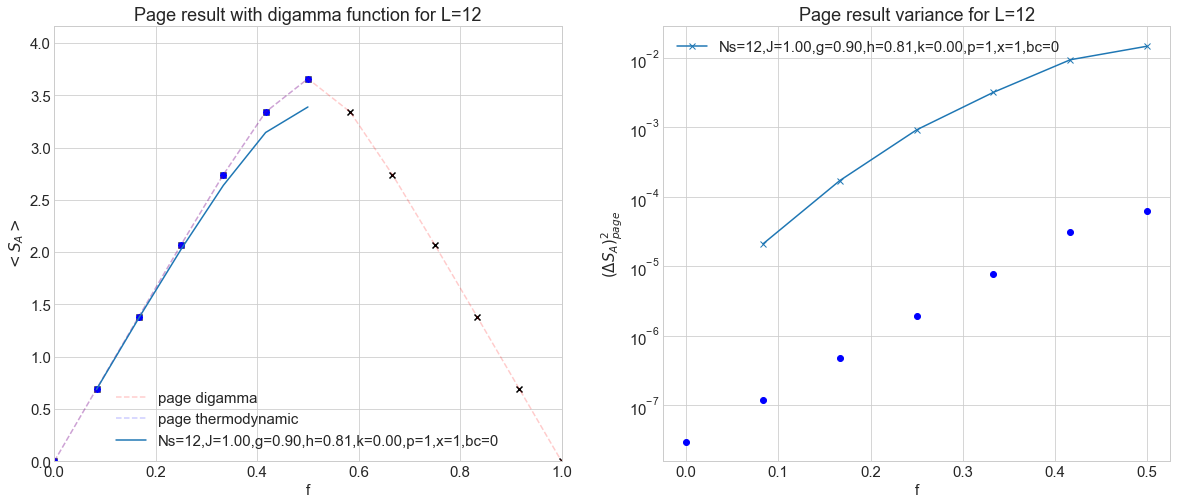

In [98]:
plot_model_av(model, fraction, directory)

### MANY

Did capture whole Hilbert space - for Ns = 12
Did capture whole Hilbert space - for Ns = 12
Did capture whole Hilbert space - for Ns = 14
Did capture whole Hilbert space - for Ns = 14
Did capture whole Hilbert space - for Ns = 16
Did capture whole Hilbert space - for Ns = 16
	->For 18 missing (0, 1),frac=0.2
Didnt capture whole Hilbert space - for Ns = 18
	->For 18 missing variance (0, 1),frac=0.2
Didnt capture whole Hilbert space - for Ns = 18


C:\Users\maxgr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


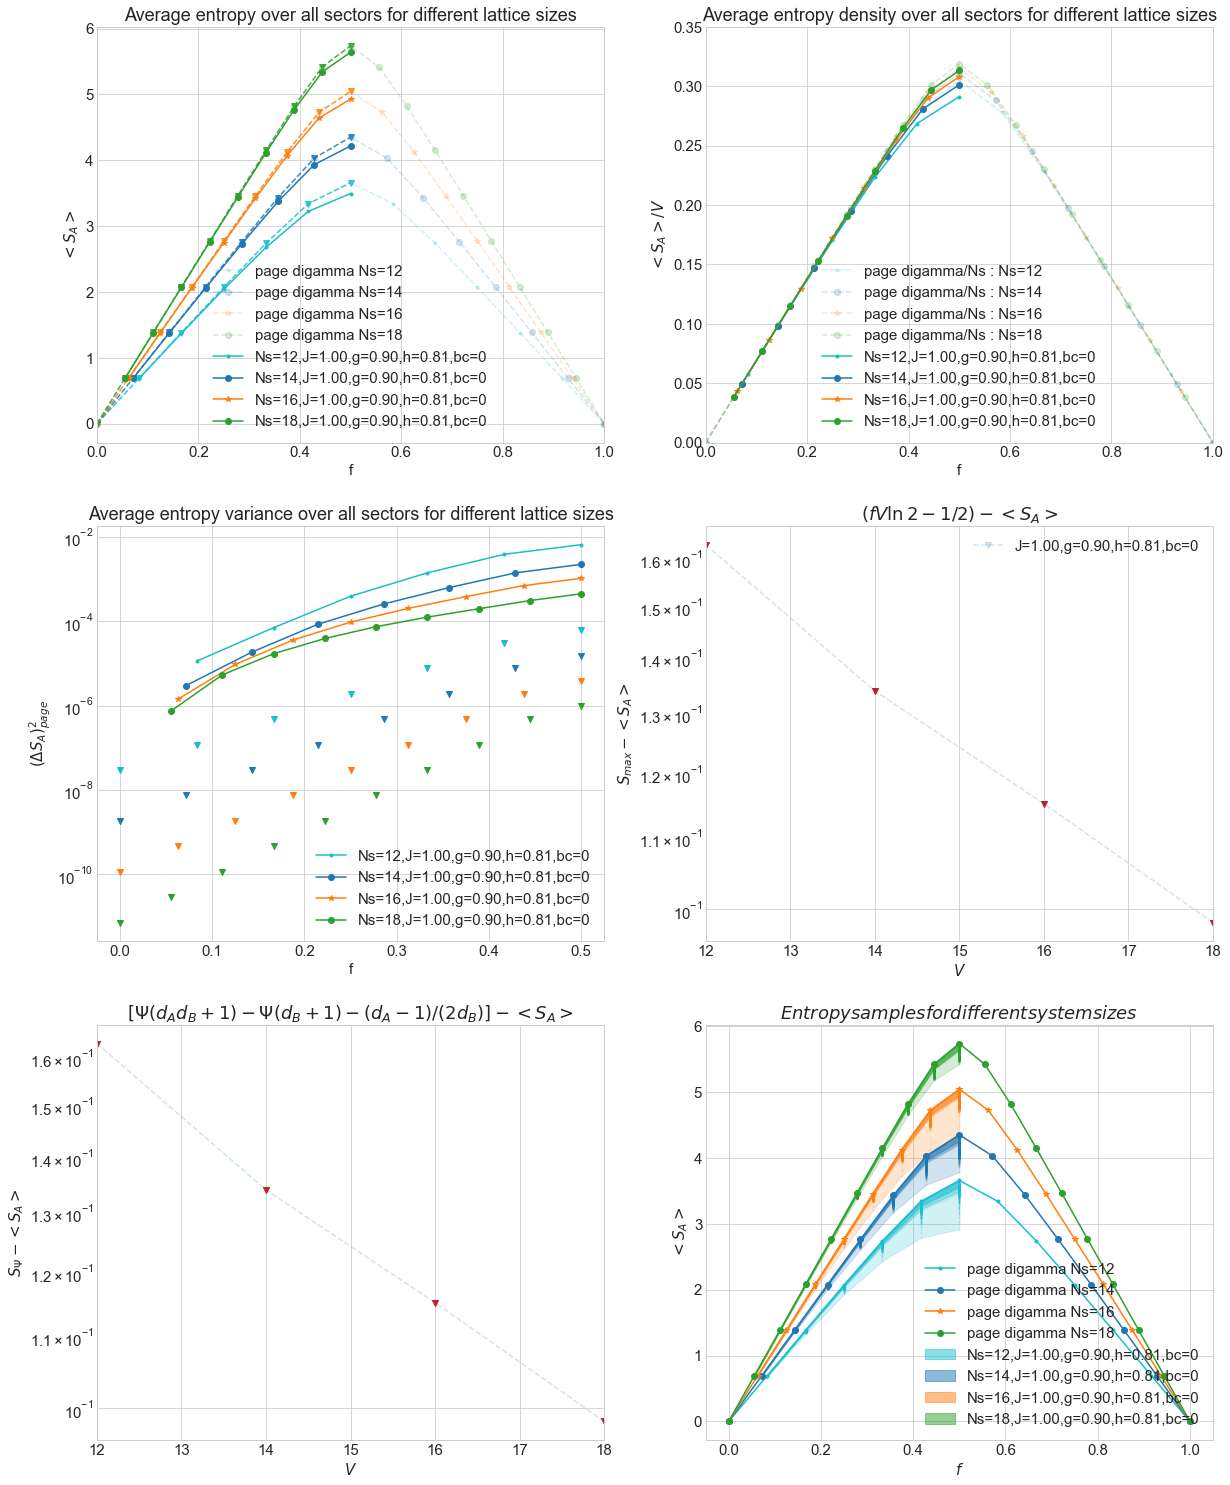

In [157]:
Ls=[12, 14, 16, 18]
plot_model_avs(Ls, model, fraction, directory, False, False)


## ED

### MODEL

In [154]:
Ns = 16
g = 0.90
h = 0.81

J = 1.0
w = 0.05
g0 = 0.0
J0 = 0.0

sym = False
k = 0.0
p = 1
x = 1

fraction=0.20

model = ising_transverse(Ns, J, J0, g, g0, h, w, sym, k, p, x)
directory = f"{kPSep}results{kPSep}resultsSym"

### SINGLE

C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: overflow encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))


(      L_a      av_S
 0  0.0625  0.689391
 1  0.1250  1.376370
 2  0.1875  2.054660
 3  0.2500  2.723300
 4  0.3125  3.374600
 5  0.3750  3.988220
 6  0.4375  4.505050
 7  0.5000  4.752720,
 '13107')

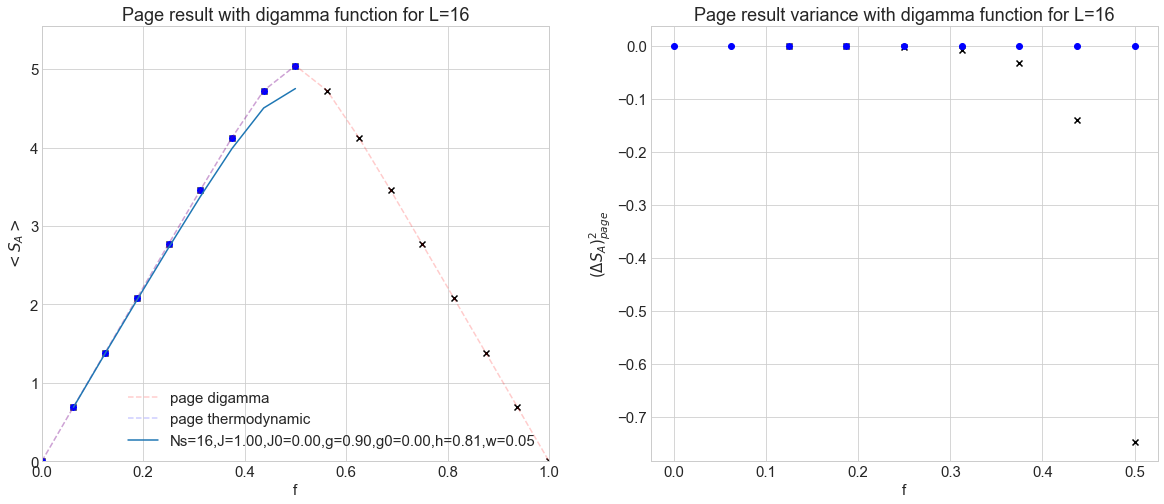

In [55]:
plot_model_av(model, fraction, directory)

### MULTIPLE

C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: overflow encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: invalid value encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))
C:\Users\maxgr\AppData\Local\Temp\ipykernel_1112\516729095.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  return (d_a + d_b)/(d_a*d_b + 1.0) * polygamma(1, d_b + 1) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2 * d_b - 1))/(4*d_b * d_b * (d_a * d_b  + 1))


5    0.621293
Name: av_S, dtype: float64
6    0.42626
Name: av_S, dtype: float64
7    0.292457
Name: av_S, dtype: float64


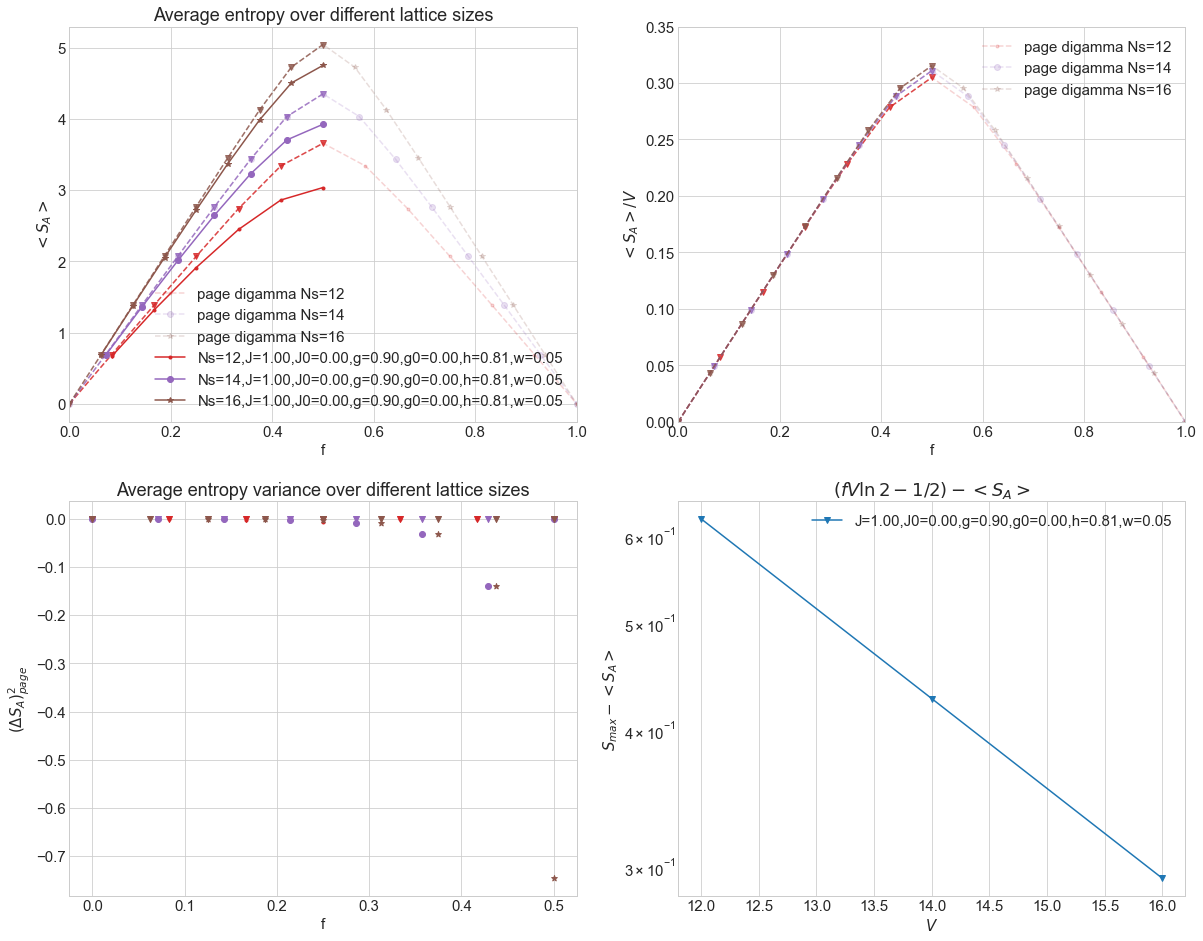

In [155]:
Ls=[12, 14, 16]
plot_model_avs(Ls, model, fraction, directory)